In [3]:
from deepcrypto.data_utils.crawlers.binance_crawler import *
from deepcrypto.data_utils import *
from deepcrypto.backtest import *
from deepcrypto.portfolio_analysis import all_metrics, save_results

from scipy import stats
from sklearn.linear_model import LogisticRegression, LinearRegression
from warnings import filterwarnings

import quantstats as qs

In [4]:
np.random.seed(5)

In [5]:
filterwarnings("ignore")

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
plt.style.use("seaborn")

In [7]:
PERIOD = 200
SYMBOL = "BTCUSDT"

In [9]:
df = read_binance_data("/home/ych/Storage/binance/binance.db", "1H", SYMBOL)

In [10]:
df = df.backtest.add_defaults()

In [11]:
df["return"] = df["close"].pct_change(PERIOD)
df["future_return"] = df["return"].shift(-PERIOD)

In [12]:
df[f"mean"] = df["close"].rolling(PERIOD).mean()
df[f"std"] = df["close"].rolling(PERIOD).std()

In [13]:
df = df.dropna()

In [14]:
df[f"pdf"] = stats.norm(df[f"mean"], df[f"std"]).pdf(df["close"])
df[f"entropy"] = -df["pdf"] * np.log2(df["pdf"])

Text(0, 0.5, 'entropy')

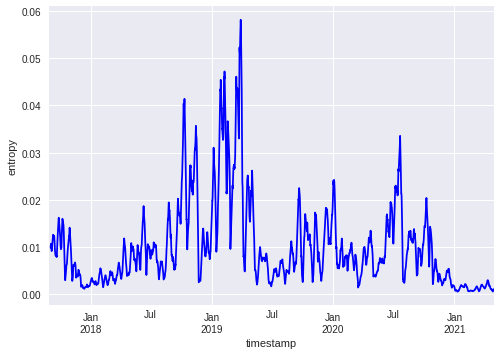

In [15]:
df["entropy"].rolling(PERIOD).mean().plot(color="blue")
plt.ylabel("entropy")

In [16]:
df["skewness"] = df["close"].rolling(PERIOD).skew().abs()

Text(0, 0.5, 'skewness')

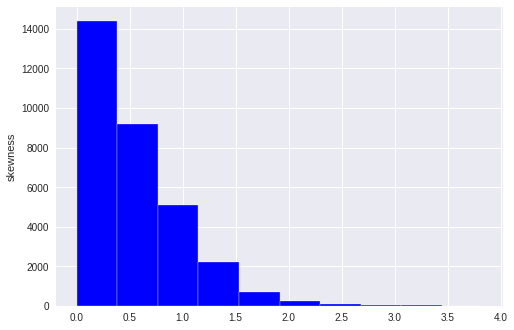

In [17]:
df["skewness"].hist(color="blue")
plt.ylabel("skewness")

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32261 entries, 2017-08-25 12:00:00 to 2021-04-30 16:00:00
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   open           32261 non-null  float64
 1   high           32261 non-null  float64
 2   low            32261 non-null  float64
 3   close          32261 non-null  float64
 4   volume         32261 non-null  float64
 5   enter_long     32261 non-null  int64  
 6   enter_short    32261 non-null  int64  
 7   close_long     32261 non-null  int64  
 8   close_short    32261 non-null  int64  
 9   bet            32261 non-null  int64  
 10  stop_loss      32261 non-null  float64
 11  take_profit    32261 non-null  float64
 12  time_cut       32261 non-null  float64
 13  trade_cost     32261 non-null  int64  
 14  slippage       32261 non-null  int64  
 15  low_first      32261 non-null  int64  
 16  return         32261 non-null  float64
 17  future_return  

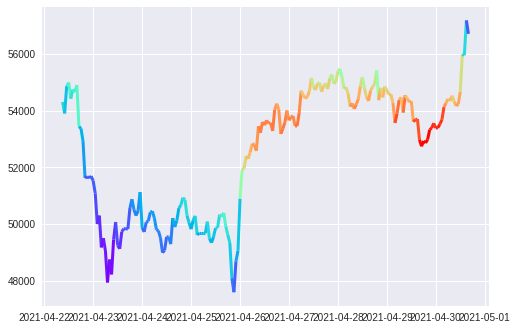

In [19]:
c = df[-PERIOD:].entropy.values 
dates = df[-PERIOD:].index.values
y = df[-PERIOD:].close.values

from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

fig, ax = plt.subplots()

#convert dates to numbers first
inxval = mdates.date2num(dates)
points = np.array([inxval, y]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]], axis=1)

lc = LineCollection(segments, cmap="rainbow", linewidth=3)
# set color to date values
lc.set_array(c)
ax.add_collection(lc)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.autoscale_view()
plt.show()

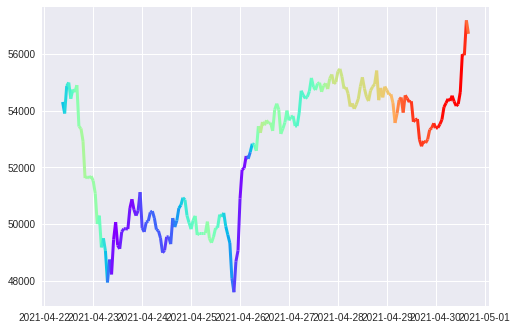

In [20]:
c = df[-PERIOD:].skewness.values 
dates = df[-PERIOD:].index.values
y = df[-PERIOD:].close.values

from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

fig, ax = plt.subplots()

#convert dates to numbers first
inxval = mdates.date2num(dates)
points = np.array([inxval, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1],points[1:]], axis=1)

lc = LineCollection(segments, cmap="rainbow", linewidth=3)
# set color to date values
lc.set_array(c)
ax.add_collection(lc)

loc = mdates.AutoDateLocator()
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))
ax.autoscale_view()
plt.show()

Text(0, 0.5, 'change(%) for 200')

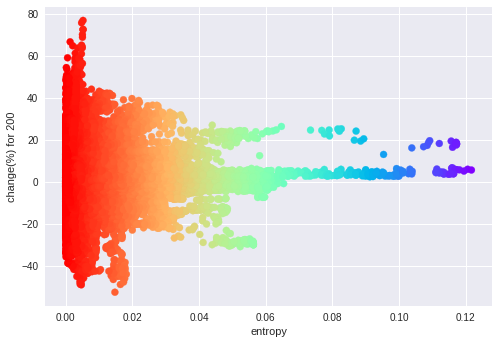

In [21]:
plt.scatter(df["entropy"], df["return"].shift(-PERIOD) * 100, c=-df["entropy"], cmap=plt.cm.rainbow)
plt.xlabel("entropy")
plt.ylabel(f"change(%) for {PERIOD}")

Text(0, 0.5, 'stdev for returns(%) for 200')

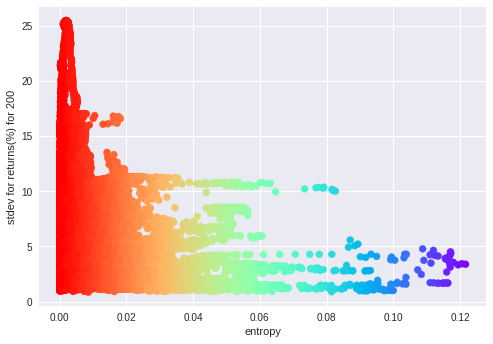

In [22]:
plt.scatter(
    df["entropy"], 
    df["return"].rolling(PERIOD).std().shift(-PERIOD) * 100, 
    c=-df["entropy"], 
    cmap=plt.cm.rainbow
)
plt.xlabel("entropy")
plt.ylabel(f"stdev for returns(%) for {PERIOD}")

In [23]:
df_highent = df[(df["entropy"] < 0.2)]
df_highent = df[(df["skewness"]) < 1]

In [24]:
df_linreg = df_highent[["return", "future_return", "entropy"]]
df_linreg["future_return_mean"] = df_linreg["future_return"].rolling(PERIOD).mean()
df_linreg = df_linreg.dropna()

In [25]:
regressor = LinearRegression()
regressor.fit(df_linreg["return"].values.reshape(-1, 1), df_linreg["future_return_mean"].values.reshape(-1, 1))

LinearRegression()

In [26]:
reg_X = np.array(sorted(df_linreg["return"].values)).reshape(-1, 1)
reg_pred = regressor.predict(reg_X)
reg_X = reg_X.squeeze()

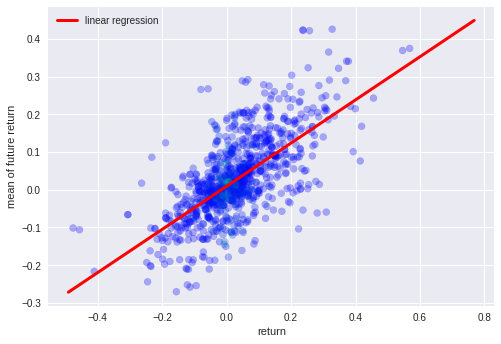

In [27]:
np.random.seed(42)
index = np.random.randint(0, len(reg_X), size=1000)
plt.scatter(
    df_linreg["return"].iloc[index],
    df_linreg["future_return_mean"].iloc[index],
    c=df_linreg["entropy"].iloc[index],
    cmap=plt.cm.winter,
    alpha=0.3,
)

plt.plot(
    reg_X, 
    reg_pred,
    color="red",
    linewidth=3,
    label="linear regression"
)

plt.xlabel("return")
plt.ylabel("mean of future return")
plt.legend()

In [28]:
df_linreg[["return", "future_return_mean"]].corr()

,return,future_return_mean
return,1.000000,0.689101
future_return_mean,0.689101,1.000000


<AxesSubplot:>

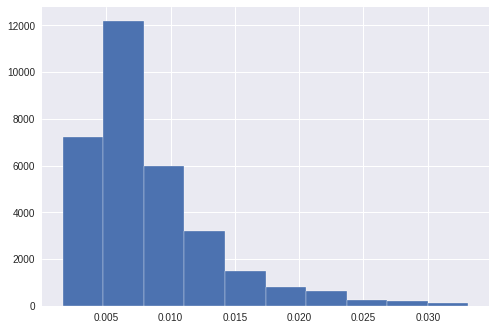

In [29]:
(df["close"].pct_change().rolling(PERIOD).std()["2017-03-01":]).hist()

In [31]:
from talib.abstract import *
from ray import tune
from copy import deepcopy
import ray

In [32]:
df

,open,high,low,close,volume,enter_long,enter_short,close_long,close_short,bet,...,trade_cost,slippage,low_first,return,future_return,mean,std,pdf,entropy,skewness
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-08-25 12:00:00,4361.27,4361.27,4261.13,4309.69,110.998609,0,0,0,0,1,...,0,0,1,0.000200,0.009629,4132.71605,156.764095,0.001346,0.012834,NaN
2017-08-25 13:00:00,4309.69,4345.00,4297.66,4312.00,20.801018,0,0,0,0,1,...,0,0,1,-0.000769,-0.002892,4132.69945,156.744836,0.001323,0.012651,NaN
2017-08-25 14:00:00,4312.00,4340.00,4291.52,4305.00,10.610266,0,0,0,0,1,...,0,0,1,-0.004475,0.023229,4132.60270,156.631877,0.001390,0.013191,NaN
2017-08-25 15:00:00,4305.00,4422.29,4305.00,4394.36,21.796763,0,0,0,0,1,...,0,0,1,0.010200,0.017700,4132.82455,156.972380,0.000634,0.006738,NaN
2017-08-25 16:00:00,4394.36,4453.91,4375.29,4447.31,17.784780,0,0,0,0,1,...,0,0,1,0.019864,0.034452,4133.25765,157.721945,0.000348,0.004002,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-30 12:00:00,54230.64,54738.96,54170.89,54655.81,2294.572967,0,0,0,0,1,...,0,0,1,0.007078,0.078299,52490.98235,2183.699381,0.000112,0.001467,0.426915
2021-04-30 13:00:00,54655.81,55990.00,54409.70,55989.31,6279.547330,0,0,0,0,1,...,0,0,1,0.028124,0.049888,52498.64030,2193.295591,0.000051,0.000731,0.414979
2021-04-30 14:00:00,55989.31,56308.16,55736.24,55952.19,6046.652009,0,0,0,0,1,...,0,0,1,0.027448,0.046735,52506.11395,2202.531007,0.000053,0.000756,0.404066


In [33]:
ray.init(ignore_reinit_error=True)

2021-05-14 02:22:56,002	INFO services.py:1269 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.68.106',
 'raylet_ip_address': '192.168.68.106',
 'redis_address': '192.168.68.106:6379',
 'object_store_address': '/tmp/ray/session_2021-05-14_02-22-53_878913_45846/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-14_02-22-53_878913_45846/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-14_02-22-53_878913_45846',
 'metrics_export_port': 55820,
 'node_id': '82d3774ded9b45db289655bc85d88293bf25e985b4dbc1a51c362346'}

In [34]:
from deepcrypto.backtest import BacktestAccessor
import quantstats as qs

In [42]:
@strategy
def entropy_strategy(config, df):
    PERIOD = config["PERIOD"]
    RSI_PERIOD = config["RSI_PERIOD"]
    RETURN_PERIOD = config["RETURN_PERIOD"]
    ENTROPY_THRES = config["ENTROPY_THRES"]
    STOP_LOSS = config["STOP_LOSS"]
    TAKE_PROFIT = config["TAKE_PROFIT"]
    TIME_CUT = config["TIME_CUT"]
    SKEW_THRES = config["SKEW_THRES"]
    
    df.backtest.add_defaults()

    df["mean"] = df["close"].rolling(PERIOD).mean()
    df["std"] = df["close"].rolling(PERIOD).std()
    
    df["return"] = df["close"].pct_change(RETURN_PERIOD)
    
    df["pdf"] = stats.norm(df[f"mean"], df[f"std"]).pdf(df["close"])

    df["entropy"] = -df["pdf"] * np.log2(df["pdf"])
    
    df["skewness"] = df["close"].rolling(PERIOD).skew().abs()

    df["RSI"] = RSI(df["close"], RSI_PERIOD)

    df["enter_long"] = (
        (df["return"] > 0) 
        & (df["entropy"] < ENTROPY_THRES)  
        & (df["RSI"] > 50) 
        & (df["close"]/df["mean"] > 1)
        & (df["skewness"] < SKEW_THRES)
    )
    
    df["close_long"] = df["entropy"] > ENTROPY_THRES

#     df["enter_short"] = (
#         (df["return"] < 0) 
#         & (df["entropy"] < ENTROPY_THRES) 
#         & (df["RSI"] < 50) 
#         & (df["close"]/df["mean"] < 1)
#         & (df["skewness"] < SKEW_THRES)
#     )
#     df["close_short"] = df["entropy"] > ENTROPY_THRES

    df["time_cut"] = TIME_CUT
    df["bet"] = np.clip(0.005/df["close"].pct_change().rolling(PERIOD).std(), 0, 3) * 10
    df["trade_cost"] = 0.001
    df["take_profit"] = TAKE_PROFIT
    df["stop_loss"] = STOP_LOSS
    df["low_first"] = 1
    return df

def optimizer(config, df):
    from deepcrypto.backtest import BacktestAccessor
    portfolio_df, order_df = entropy_strategy(config, df).backtest.run()
    tune.report(**all_metrics(portfolio_df, order_df))

In [33]:
def optimize(df):
    result = tune.run(
        tune.with_parameters(optimizer, df=df),
        config = {
            "PERIOD" : tune.grid_search([50, 100, 200]),
            "RSI_PERIOD" : tune.grid_search([50, 100, 200]),
            "RETURN_PERIOD" : tune.grid_search([50, 100, 200]),
            "ENTROPY_THRES" : tune.grid_search([0.2, 0.3]),
            "STOP_LOSS" : tune.grid_search([0.02, 0.05]),
            "TAKE_PROFIT" : tune.grid_search([0.1, 0.2]),
            "TIME_CUT" : tune.grid_search([50, 100, 200]),
            "SKEW_THRES" : tune.grid_search([1, 2, 3])
        },
        local_dir="./ray_results",
    )
    return result

In [34]:
import quantstats as qs
import json, os
from pprint import pprint

do_optimize=False

if do_optimize:
    result = optimize(df[:-1])


    save_dir = f"./result/new/{SYMBOL}/"

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    from deepcrypto.portfolio_analysis import save_results

    result = tune.Analysis("/home/ych/WorkSpace/Projects/DeepCrypto/research/entropy_strategy/ray_results/_inner_2021-04-20_00-56-33")

    save_results(result.get_best_config(metric="Calmar", mode="max"), entropy_strategy, df, save_dir, "Calmar")
    save_results(result.get_best_config(metric="Sortino", mode="max"), entropy_strategy, df, save_dir, "Sortino")
    save_results(result.get_best_config(metric="MaxDrawdown", mode="max"), entropy_strategy, df, save_dir, "MaxDrawdown")
    save_results(result.get_best_config(metric="CAGR%", mode="max"), entropy_strategy, df, save_dir, "CAGR")

In [44]:
cfg = {"ENTROPY_THRES": 0.2, "PERIOD": 200, "RETURN_PERIOD": 50, "RSI_PERIOD": 200, "SKEW_THRES": 1, "STOP_LOSS": 0.05, "TAKE_PROFIT": 0.1, "TIME_CUT": 24}

order, port = entropy_strategy(cfg, df).backtest.run()

qs.reports.full(port["portfolio_value"])

backtest completed in 0.18550801277160645 seconds


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
(order.timestamp.diff() / TIMEFRAMES.DAY).mean()

<AxesSubplot:>

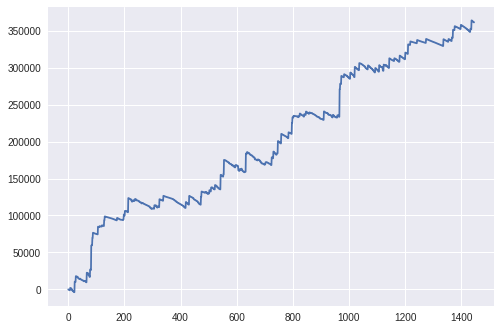

In [70]:
order.realized.cumsum().plot()

In [71]:
(np.maximum.accumulate(port.portfolio_value) - port.portfolio_value).max() / port.portfolio_value.iloc[0] * 100

319.8807844356325

<AxesSubplot:>

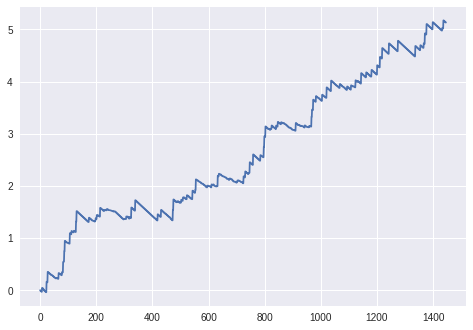

In [51]:
order.realized_percent.cumsum().plot()